<center><h2>ALTeGraD 2024<br>Lab Session 2: Transfer learning for NLP</h2> 15 / 10 / 2024<br> Dr. G. Shang, Y. Zhang<br><br>


<b>Student name:</b> DANAN Solal

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 22, 2024 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(num_embeddings=ntoken, embedding_dim=nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid=nhid) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(d_model=nhid, dim_feedforward=nhid, nhead=nhead) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layers, num_layers=nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)   #fill me
        output = self.transformer_encoder(src, mask=src_mask) #fill me
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(in_features=nhid, out_features=nclasses)    #fill me)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken=ntoken, nhead=nhead, nhid=nhid, nlayers=nlayers, dropout=dropout) #fill me
        self.classifier = ClassificationHead(nhid=nhid, nclasses=nclasses)  #fill me

    def forward(self, src, src_mask):
        # base model
        x = self.base(src, src_mask) #fill me
        # classifier model
        output = self.classifier(x) #fill me
        return output

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [4]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

torch.Size([1, 6, 100])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model is instantiated with nclasses=ntokens
Therefore, the output tensor has shape of 1 (batch size) x 6 (input size) x 100 (nclasses).

## Vocabulary and Tokenization

In [5]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2024-10-22 17:34:45--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 577587 (564K) [text/plain]
Sauvegarde en : « dict.txt.1 »

dict.txt.1          100%[===================>] 564,05K  --.-KB/s    ds 0,05s   

2024-10-22 17:34:45 (10,9 MB/s) — « dict.txt.1 » sauvegardé [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [6]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] =  idx + 4 # +4 not to overwrite thespecial tokens #fill me

ind2token = {v: k for k, v in token2ind.items()} #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [7]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1: 
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [token2ind['<sos>']] + [token2ind[token] if token in token2ind else token2ind['<oov>'] for token in sequence] #fill me (constract the input sequence using token2ind, sequence and special tokens)
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [8]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1] #fill me
        output = output.view(-1, output.shape[-1])
        target =  data[1] #fill me
        target = target.to(device)
        loss = criterion(output, target)#fill me, Cross entropy check next cells
        loss.backward() #fill me step 3

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        optimizer.step()#fill me step 4

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [9]:
ntokens = len(ind2token) #fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [10]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2024-10-22 17:34:51--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 10146460 (9,7M) [text/plain]
Sauvegarde en : « pretraining_subset.txt.1 »

pretraining_subset. 100%[===================>]   9,68M  12,9MB/s    ds 0,7s    

2024-10-22 17:34:52 (12,9 MB/s) — « pretraining_subset.txt.1 » sauvegardé [10146460/10146460]



In [12]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task='language_modeling', # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.40238 | ppl 1639.875
| epoch   1 |  1000/ 3125 steps | loss 6.60674 | ppl  740.068
| epoch   1 |  1500/ 3125 steps | loss 6.31724 | ppl  554.040
| epoch   1 |  2000/ 3125 steps | loss 6.13182 | ppl  460.275
| epoch   1 |  2500/ 3125 steps | loss 6.02134 | ppl  412.132
| epoch   1 |  3000/ 3125 steps | loss 5.90905 | ppl  368.355
| epoch   2 |   500/ 3125 steps | loss 5.65315 | ppl  285.188
| epoch   2 |  1000/ 3125 steps | loss 5.62077 | ppl  276.102
| epoch   2 |  1500/ 3125 steps | loss 5.59440 | ppl  268.916
| epoch   2 |  2000/ 3125 steps | loss 5.54185 | ppl  255.150
| epoch   2 |  2500/ 3125 steps | loss 5.52331 | ppl  250.462
| epoch   2 |  3000/ 3125 steps | loss 5.47238 | ppl  238.025


## Text Generation


In [13]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt



model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt', map_location=torch.device('cpu'))
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2024-10-22 18:06:32--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 88093955 (84M) [application/octet-stream]
Sauvegarde en : « pretrained_model_4layers.pt.3 »

pretrained_model_4l 100%[===================>]  84,01M  12,8MB/s    ds 6,5s    

2024-10-22 18:06:38 (12,9 MB/s) — « pretrained_model_4layers.pt.3 » sauvegardé [88093955/88093955]



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/var/folders/cg/ltgc1bw91_q800mfcy5vfvkw0000gn/T/ipykernel_81290/1360543851.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

<All keys matched successfully>

In [14]:
# !pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2024-10-22 18:06:39--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1115362 (1,1M) [application/octet-stream]
Sauvegarde en : « sentencepiece.french.model.2 »

sentencepiece.frenc 100%[===================>]   1,06M  --.-KB/s    ds 0,06s   

2024-10-22 18:06:39 (17,4 MB/s) — « sentencepiece.french.model.2 » sauvegardé [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [15]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] if el in token2ind else token2ind['<oov>'] for el in sent_pieces]  # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = torch.argmax(out[-1, :]).item() #fill me
    return next_token_ind, out


def infer_next_tokens(sent, max_len=50):
    # to be implemented
    # Encode the input sequence into subword tokens
    token_pieces = s.encode_as_pieces(sent)
    
    # Convert the pieces into their corresponding token indices
    token_ids = [token2ind['<sos>']] + [token2ind[piece] if piece in token2ind else token2ind['<oov>'] for piece in token_pieces]

    # Iteratively predict the next token up to max_length or until <eos> is generated
    for _ in range(max_len):
        # Decode the current token indices into a sentence
        current_sequence = s.decode([ind2token[tok] for tok in token_ids if tok in ind2token])
        
        # Infer the next token index using the current sequence
        next_token_index, _ = infer_next_token(current_sequence)
        token_ids.append(next_token_index)

        # Stop if the end of sequence token is generated
        if next_token_index == token2ind['<eos>']:
            break

    # Decode the final sequence of tokens into a string and return it
    return s.decode([ind2token[tok] for tok in token_ids if tok in ind2token])

In [16]:
sent = "Bonjour les"
infer_next_tokens(sent)

'<sos> Bonjour les gens qui ont été très accueillants et sympathiques.<eos>'

In [17]:
sent = "Il fait froid aujourd'hui"
infer_next_tokens(sent)

"<sos> Il fait froid aujourd'hui, je suis un peu plus loin.<eos>"

In [18]:
sent = "Hello Sir,"
infer_next_tokens(sent)

"<sos> Hello Sir, c'est le cas de la vie de la famille des amis, c'est le cas de la famille des amis.<eos>"

### Supervised task

In [19]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2024-10-22 18:06:40--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1495960 (1,4M) [text/plain]
Sauvegarde en : « train.review.spm.1 »

train.review.spm.1  100%[===================>]   1,43M  --.-KB/s    ds 0,09s   

2024-10-22 18:06:40 (15,9 MB/s) — « train.review.spm.1 » sauvegardé [1495960/1495960]

--2024-10-22 18:06:41--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443… conne

In [20]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    #to be implemented
    model.eval()
    total_loss = 0.0
    ncorrect = ntotal = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            # inference 
            src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(device)
            output = model(data[0].to(device), src_mask)[-1] 
            # total number of examples
            ntotal +=  output.shape[0]
            # number of correct predictions 
            predictions = torch.argmax(output, axis=1)
            ncorrect += torch.sum(data[1].to(device) == predictions)
        acc = ncorrect.item() / ntotal
        return acc

In [21]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [22]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)


=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.75527 | ppl    2.128
| epoch   1 |   100/  200 steps | loss 0.71986 | ppl    2.054
| epoch   1 |   150/  200 steps | loss 0.72094 | ppl    2.056
| epoch   2 |    50/  200 steps | loss 0.71128 | ppl    2.037
| epoch   2 |   100/  200 steps | loss 0.65528 | ppl    1.926
| epoch   2 |   150/  200 steps | loss 0.73135 | ppl    2.078
| epoch   3 |    50/  200 steps | loss 0.59190 | ppl    1.807
| epoch   3 |   100/  200 steps | loss 0.69980 | ppl    2.013
| epoch   3 |   150/  200 steps | loss 0.44783 | ppl    1.565
| epoch   4 |    50/  200 steps | loss 0.29308 | ppl    1.341
| epoch   4 |   100/  200 steps | loss 0.18432 | ppl    1.202
| epoch   4 |   150/  200 steps | loss 0.34692 | ppl    1.415
| epoch   5 |    50/  200 steps | loss 0.08972 | ppl    1.094
| epoch   5 |   100/  200 steps | loss 0.08162 | ppl    1.085
| epoch   5 |   150/  200 steps | loss 0.07841 | ppl    1.082
| epoch   6 |    50/  200 steps | loss

/var/folders/cg/ltgc1bw91_q800mfcy5vfvkw0000gn/T/ipykernel_81290/1374578445.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_model_4l

| epoch   1 |    50/  200 steps | loss 0.78563 | ppl    2.194
| epoch   1 |   100/  200 steps | loss 0.69117 | ppl    1.996
| epoch   1 |   150/  200 steps | loss 0.63406 | ppl    1.885
| epoch   2 |    50/  200 steps | loss 0.54268 | ppl    1.721
| epoch   2 |   100/  200 steps | loss 0.51420 | ppl    1.672
| epoch   2 |   150/  200 steps | loss 0.49309 | ppl    1.637
| epoch   3 |    50/  200 steps | loss 0.40725 | ppl    1.503
| epoch   3 |   100/  200 steps | loss 0.37177 | ppl    1.450
| epoch   3 |   150/  200 steps | loss 0.50461 | ppl    1.656
| epoch   4 |    50/  200 steps | loss 0.30493 | ppl    1.357
| epoch   4 |   100/  200 steps | loss 0.37235 | ppl    1.451
| epoch   4 |   150/  200 steps | loss 0.37010 | ppl    1.448
| epoch   5 |    50/  200 steps | loss 0.30248 | ppl    1.353
| epoch   5 |   100/  200 steps | loss 0.34530 | ppl    1.412
| epoch   5 |   150/  200 steps | loss 0.31502 | ppl    1.370
| epoch   6 |    50/  200 steps | loss 0.30759 | ppl    1.360
| epoch 

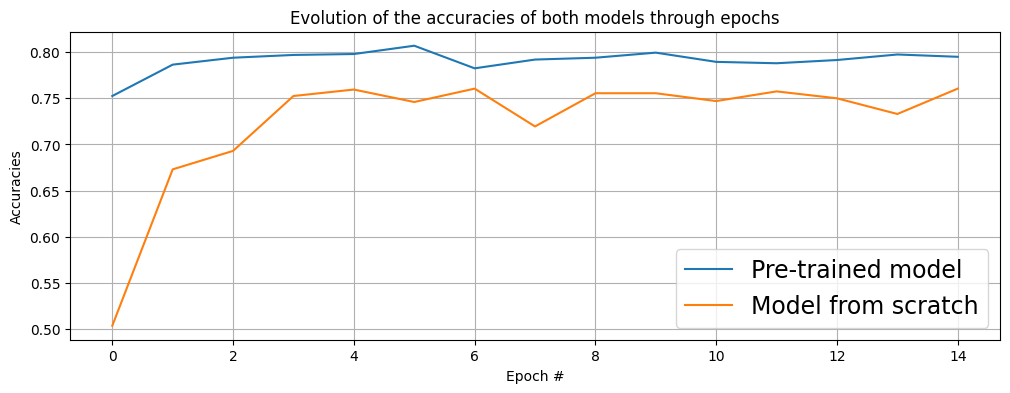

In [25]:
#Visualize the accuracy
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(pretrained_valid_acc, label="Pre-trained model")
ax.plot(from_scratch_valid_acc, label = 'Model from scratch')
ax.set_ylabel('Accuracies')
ax.set_xlabel('Epoch #')
ax.grid()
ax.legend(fontsize=17)
ax.set_title('Evolution of the accuracies of both models through epochs')
plt.show()